# ***News Topic Classifier Using BERT***

## ***Import Libraries***

In [ ]:
# Install the necessary Hugging Face and processing libraries
!pip install -q transformers[torch] datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
# 1. Install Gradio
!pip install -q gradio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

import evaluate

from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, pipeline
from datasets import load_dataset
import gradio as gr
from huggingface_hub import notebook_login




In [ ]:
# Load the dataset
dataset = load_dataset("ag_news")

# Check the labels mapping
labels = dataset["train"].features["label"].names
num_labels = len(labels)
print(num_labels)
print(f"Labels: {labels}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 0938e790-f167-45b2-ac4d-2b8bd1192001)')' thrown while requesting HEAD https://huggingface.co/datasets/fancyzhx/ag_news/resolve/eb185aade064a813bc0b7f42de02595523103ca4/data/test-00000-of-00001.parquet
Retrying in 1s [Retry 1/5].


data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

4
Labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
dataset["train"][:5]

{'text': ["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
  'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.',
  "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.",
  'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.',
  'Oil prices soar to all-time record, posing new menace to 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(examples):
    # Padding and truncation are essential for BERT's 512-token limit
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenization to the whole dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [ ]:
training_args = TrainingArguments(
    output_dir="./bert-news-classifier",
    eval_strategy="epoch",      # Evaluate at the end of every epoch
    save_strategy="epoch",
    learning_rate='2e-5',          # Standard BERT fine-tuning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,          # BERT usually converges in 2-4 epochs
    weight_decay=0.01,
    load_best_model_at_end=True,
    fp16=True,                   # Enable mixed precision for faster training on GPU
    report_to="none"             # Prevents logging to external tools like W&B unless set up
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.191500,0.179540,0.943684
2,0.129800,0.191395,0.945921
3,0.079800,0.237701,0.945658


TrainOutput(global_step=22500, training_loss=0.14869991099039714, metrics={'train_runtime': 2743.9275, 'train_samples_per_second': 131.199, 'train_steps_per_second': 8.2, 'total_flos': 2.368042020864e+16, 'train_loss': 0.14869991099039714, 'epoch': 3.0})

In [ ]:
# Create a classification pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Test headline
headline = "The central bank decided to raise interest rates to combat inflation."
prediction = classifier(headline)

# Map the label ID back to the class name
label_idx = int(prediction[0]['label'].split('_')[-1])
print(f"Headline: {headline}")
print(f"Predicted Category: {labels[label_idx]} (Score: {prediction[0]['score']:.4f})")


Device set to use cuda:0


Headline: The central bank decided to raise interest rates to combat inflation.
Predicted Category: Business (Score: 0.9656)


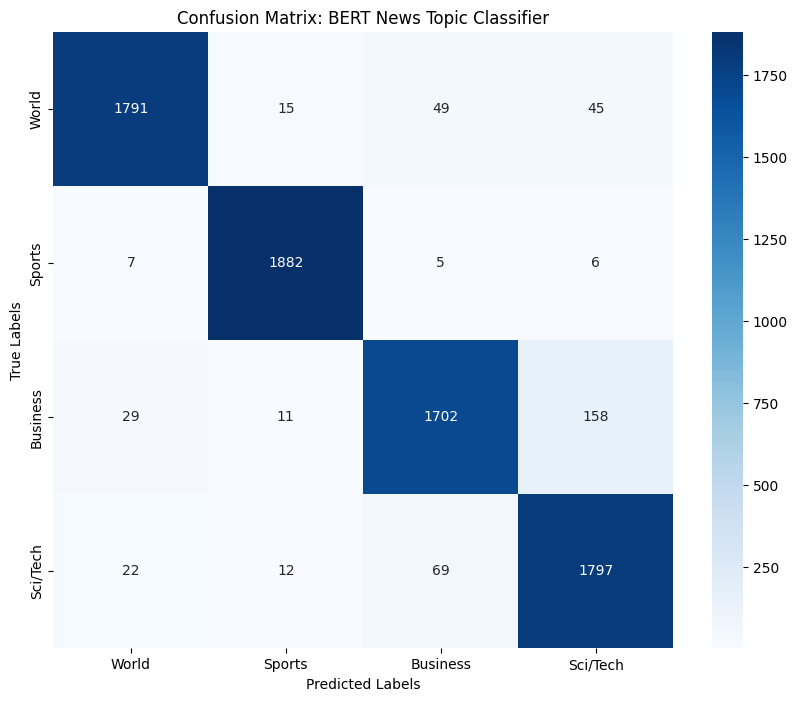


Classification Report:

              precision    recall  f1-score   support

       World       0.97      0.94      0.96      1900
      Sports       0.98      0.99      0.99      1900
    Business       0.93      0.90      0.91      1900
    Sci/Tech       0.90      0.95      0.92      1900

    accuracy                           0.94      7600
   macro avg       0.94      0.94      0.94      7600
weighted avg       0.94      0.94      0.94      7600



In [ ]:
# 1. Get predictions on the test set
output = trainer.predict(tokenized_dataset["test"])
y_true = output.label_ids
y_pred = np.argmax(output.predictions, axis=-1)

# 2. Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plotting using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: BERT News Topic Classifier')
plt.show()

# 4. Print detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save model and tokenizer to your Drive
model.save_pretrained("/content/drive/MyDrive/bert-news-classifier")
tokenizer.save_pretrained("/content/drive/MyDrive/bert-news-classifier")

Mounted at /content/drive


('/content/drive/MyDrive/bert-news-classifier/tokenizer_config.json',
 '/content/drive/MyDrive/bert-news-classifier/special_tokens_map.json',
 '/content/drive/MyDrive/bert-news-classifier/vocab.txt',
 '/content/drive/MyDrive/bert-news-classifier/added_tokens.json',
 '/content/drive/MyDrive/bert-news-classifier/tokenizer.json')

In [ ]:
# 2. Define the prediction function
def classify_news(text):
    # Get predictions from the pipeline
    # We set top_k=None to get probabilities for ALL categories
    predictions = classifier(text, top_k=None)

    # Format the results for Gradio's Label component
    # It expects a dictionary: {"Category Name": probability_float}
    formatted_outputs = {}
    for pred in predictions:
        label_idx = int(pred['label'].split('_')[-1])
        label_name = labels[label_idx]
        formatted_outputs[label_name] = float(pred['score'])

    return formatted_outputs



In [ ]:
# 3. Create the Gradio Interface
demo = gr.Interface(
    fn=classify_news,
    inputs=gr.Textbox(lines=3, placeholder="Enter a news headline or snippet here...", label="News Text"),
    outputs=gr.Label(num_top_classes=4, label="Topic Prediction"),
    title="BERT News Topic Classifier",
    description="This model uses BERT fine-tuned on the AG News dataset to categorize news into World, Sports, Business, or Sci/Tech.",
    examples=[
        ["The local soccer team won the championship after a dramatic penalty shootout."],
        ["Global markets tumbled today as investors reacted to new inflation data."],
        ["NASA's latest rover has successfully landed on the Martian surface to look for signs of water."],
        ["Diplomats are meeting in Geneva to discuss a new ceasefire agreement."]
    ]
)



In [ ]:
# 4. Launch the app
# share=True creates a public URL you can send to anyone for 72 hours
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fc426519b35d1ac18a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!zip -r model.zip ./bert-news-classifier
from google.colab import files
files.download('model.zip')

  adding: bert-news-classifier/ (stored 0%)
  adding: bert-news-classifier/checkpoint-15000/ (stored 0%)
  adding: bert-news-classifier/checkpoint-15000/training_args.bin (deflated 53%)
  adding: bert-news-classifier/checkpoint-15000/config.json (deflated 52%)
  adding: bert-news-classifier/checkpoint-15000/scheduler.pt (deflated 61%)
  adding: bert-news-classifier/checkpoint-15000/optimizer.pt (deflated 13%)
  adding: bert-news-classifier/checkpoint-15000/trainer_state.json (deflated 77%)
  adding: bert-news-classifier/checkpoint-15000/scaler.pt (deflated 64%)
  adding: bert-news-classifier/checkpoint-15000/model.safetensors (deflated 7%)
  adding: bert-news-classifier/checkpoint-15000/rng_state.pth (deflated 26%)
  adding: bert-news-classifier/checkpoint-7500/ (stored 0%)
  adding: bert-news-classifier/checkpoint-7500/training_args.bin (deflated 53%)
  adding: bert-news-classifier/checkpoint-7500/config.json (deflated 52%)
  adding: bert-news-classifier/checkpoint-7500/scheduler.pt (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 1. Log in (it will provide a link to get your Access Token)
# Ensure your token has 'WRITE' permissions
notebook_login()

# 2. Push the model and tokenizer to the Hub
# Replace 'your-username' with your actual Hugging Face username
model_name = "bert-news-classifier-agnews"
model.push_to_hub(model_name)
tokenizer.push_to_hub(model_name)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...wbtw4qz/model.safetensors:   0%|          | 14.2kB /  438MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/fawad5/bert-news-classifier-agnews/commit/7c4312a7d1ced21a922584093b15d09e7b31f167', commit_message='Upload tokenizer', commit_description='', oid='7c4312a7d1ced21a922584093b15d09e7b31f167', pr_url=None, repo_url=RepoUrl('https://huggingface.co/fawad5/bert-news-classifier-agnews', endpoint='https://huggingface.co', repo_type='model', repo_id='fawad5/bert-news-classifier-agnews'), pr_revision=None, pr_num=None)